<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/4th%20sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

In [119]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [120]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [121]:
train.shape

(91075, 31)

In [122]:
train = pd.concat([train, target], axis=1)

In [123]:
features = [f for f in train.columns if 'feature' in f]
len(features)

29

((68306, 122), (22769, 122))

In [28]:
# valid = train[train['moons'] > 34]
# valid = valid.reset_index(drop=True)

# train = train[train['moons'] <= 34]
# train.reset_index(drop=True, inplace=True)

# cols_drop = ['id', 'moons']
# train.drop(columns= cols_drop, inplace=True)
# valid.drop(columns= cols_drop, inplace=True)


In [ ]:
!pip install optuna

In [137]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
    return score

In [138]:
N_TRIALS = 200

In [157]:
import optuna
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(train[features], train['target_r'], test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape)
tr_data = lgb.Dataset(X_train, y_train)
va_data = lgb.Dataset(X_test, y_test)
def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 4, 32),
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'max_depth': trial.suggest_int('max_depth', 4, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
            'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'max_bin': trial.suggest_int('max_bin', 50, 900),
            'early_stopping_rounds': 100, 
            }

    model = lgb.train(params, tr_data, valid_sets=[tr_data, va_data], verbose_eval=None, num_boost_round=10000)
    score = model.best_score['valid_1']['rmse']
    print(score)
    val_pred = model.predict(X_test)
    spearman_score = scorer(y_test, val_pred)
    # from google.colab import output
    # output.clear()
    return score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar= True)

print("target_r") 
display(study.best_params)
display(study.best_trial.value)


[I 2021-03-13 11:50:21,676] A new study created in memory with name: no-name-eb0cb05b-fa74-4be1-8822-66fcc04baa75


(68306, 29) (22769, 29)


0.336117556175449
Score as calculated for the leader board (っಠ‿ಠ)っ 0.3605057305943311
[I 2021-03-13 11:50:54,387] Trial 0 finished with value: 0.336117556175449 and parameters: {'num_leaves': 9, 'max_depth': 12, 'min_child_weight': 1, 'feature_fraction': 0.8357216698282923, 'bagging_fraction': 0.499075379690438, 'bagging_freq': 1, 'min_child_samples': 62, 'lambda_l1': 8.931537494692723e-05, 'lambda_l2': 2.783296284976346e-07, 'learning_rate': 0.0006535141122218853, 'max_bin': 460}. Best is trial 0 with value: 0.336117556175449.
0.3383288116237472
Score as calculated for the leader board (っಠ‿ಠ)っ 0.34461720907717275
[I 2021-03-13 11:50:54,923] Trial 1 finished with value: 0.3383288116237472 and parameters: {'num_leaves': 12, 'max_depth': 8, 'min_child_weight': 12, 'feature_fraction': 0.5906655965015959, 'bagging_fraction': 0.9384474447237755, 'bagging_freq': 4, 'min_child_samples': 73, 'lambda_l1': 0.044715536559149484, 'lambda_l2': 0.11087042366725454, 'learning_rate': 0.750417761216608

{'bagging_fraction': 0.8344025076988906,
 'bagging_freq': 8,
 'feature_fraction': 0.40005937858347834,
 'lambda_l1': 1.8022142211316648e-06,
 'lambda_l2': 1.9452265664978631e-07,
 'learning_rate': 0.047727847948849246,
 'max_bin': 900,
 'max_depth': 13,
 'min_child_samples': 27,
 'min_child_weight': 10,
 'num_leaves': 29}

0.33505301027699136

In [160]:
import optuna
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(train[features], train['target_g'], test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape)
tr_data = lgb.Dataset(X_train, y_train)
va_data = lgb.Dataset(X_test, y_test)


def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 4, 32),
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'max_depth': trial.suggest_int('max_depth', 4, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
            'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'max_bin': trial.suggest_int('max_bin', 50, 900),
            'early_stopping_rounds': 100, 
            }

    model = lgb.train(params, tr_data, valid_sets=[tr_data, va_data], verbose_eval=None, num_boost_round=5000)

    val_pred = model.predict(X_test)
    score = model.best_score['valid_1']['rmse']
    print(score)
    val_pred = model.predict(X_test)
    spearman_score = scorer(y_test, val_pred)
    from google.colab import output
    output.clear()
    return score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar= True)
print("target_g") 
display(study.best_params)
display(study.best_trial.value)

[I 2021-03-13 12:15:58,936] Trial 199 finished with value: 0.3000460390783041 and parameters: {'num_leaves': 23, 'max_depth': 10, 'min_child_weight': 6, 'feature_fraction': 0.4123680079982971, 'bagging_fraction': 0.4953354615489961, 'bagging_freq': 1, 'min_child_samples': 71, 'lambda_l1': 0.0003842869322362984, 'lambda_l2': 2.948422629038904e-08, 'learning_rate': 0.04100095608422001, 'max_bin': 395}. Best is trial 33 with value: 0.29918586550315435.

target_g


{'bagging_fraction': 0.4755376416325456,
 'bagging_freq': 1,
 'feature_fraction': 0.40034816566766196,
 'lambda_l1': 0.00046142221019364706,
 'lambda_l2': 0.06782452424965912,
 'learning_rate': 0.07120548037141156,
 'max_bin': 492,
 'max_depth': 5,
 'min_child_samples': 9,
 'min_child_weight': 13,
 'num_leaves': 23}

0.29918586550315435

In [161]:
import optuna
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(train[features], train['target_b'], test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape)
tr_data = lgb.Dataset(X_train, y_train)
va_data = lgb.Dataset(X_test, y_test)


def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 4, 32),
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'max_depth': trial.suggest_int('max_depth', 4, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
            'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'max_bin': trial.suggest_int('max_bin', 50, 900),
            'early_stopping_rounds': 100, 
            }

    model = lgb.train(params, tr_data, valid_sets=[tr_data, va_data], verbose_eval=None, num_boost_round=5000)

    val_pred = model.predict(X_test)
    score = model.best_score['valid_1']['rmse']
    print(score)
    val_pred = model.predict(X_test)
    spearman_score = scorer(y_test, val_pred)
    from google.colab import output
    output.clear()
    return score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar= True)
print("target_b") 
display(study.best_params)
display(study.best_trial.value)

[I 2021-03-13 12:18:44,180] Trial 199 finished with value: 0.2639298852533017 and parameters: {'num_leaves': 4, 'max_depth': 4, 'min_child_weight': 10, 'feature_fraction': 0.47110040968090117, 'bagging_fraction': 0.7299650395677773, 'bagging_freq': 2, 'min_child_samples': 36, 'lambda_l1': 9.072931263812068e-07, 'lambda_l2': 0.3267618122856045, 'learning_rate': 0.2473303003368587, 'max_bin': 371}. Best is trial 134 with value: 0.26264699792627993.

target_b


{'bagging_fraction': 0.44935969936943254,
 'bagging_freq': 2,
 'feature_fraction': 0.5079540925265467,
 'lambda_l1': 3.2245733057069083e-06,
 'lambda_l2': 0.5890949933785449,
 'learning_rate': 0.16701912554238768,
 'max_bin': 154,
 'max_depth': 4,
 'min_child_samples': 4,
 'min_child_weight': 9,
 'num_leaves': 4}

0.26264699792627993

In [162]:
params_1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_fraction': 0.8344025076988906,
    'bagging_freq': 8,
    'feature_fraction': 0.40005937858347834,
    'lambda_l1': 1.8022142211316648e-06,
    'lambda_l2': 1.9452265664978631e-07,
    'learning_rate': 0.047727847948849246,
    'max_bin': 900,
    'max_depth': 13,
    'min_child_samples': 27,
    'min_child_weight': 10,
    'num_leaves': 29,
    'early_stopping_rounds': 100, 
}
X_train, X_test, y_train, y_test = train_test_split(train[features], train['target_r'], test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape)
tr_data = lgb.Dataset(X_train, y_train)
va_data = lgb.Dataset(X_test, y_test)
model_target_r = lgb.train(params_1, tr_data, valid_sets=[tr_data, va_data], verbose_eval=1000, num_boost_round=5000)
pred = model_target_r.predict(X_test)
scorer(y_test, pred)

(68306, 29) (22769, 29)
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	training's rmse: 0.321116	valid_1's rmse: 0.335053
Score as calculated for the leader board (っಠ‿ಠ)っ 0.3662931284580007


0.3662931284580007

In [164]:
params_2 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_fraction': 0.4755376416325456,
 'bagging_freq': 1,
 'feature_fraction': 0.40034816566766196,
 'lambda_l1': 0.00046142221019364706,
 'lambda_l2': 0.06782452424965912,
 'learning_rate': 0.07120548037141156,
 'max_bin': 492,
 'max_depth': 5,
 'min_child_samples': 9,
 'min_child_weight': 13,
 'num_leaves': 23,
    'early_stopping_rounds': 100, 
}
X_train, X_test, y_train, y_test = train_test_split(train[features], train['target_g'], test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape)
tr_data = lgb.Dataset(X_train, y_train)
va_data = lgb.Dataset(X_test, y_test)
model_target_g = lgb.train(params_2, tr_data, valid_sets=[tr_data, va_data], verbose_eval=1000, num_boost_round=5000)
pred = model_target_g.predict(X_test)
scorer(y_test, pred)

(68306, 29) (22769, 29)
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	training's rmse: 0.302322	valid_1's rmse: 0.299186
Score as calculated for the leader board (っಠ‿ಠ)っ 0.5315866735190697


0.5315866735190697

In [176]:
params_3 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_fraction': 0.44935969936943254,
 'bagging_freq': 2,
 'feature_fraction': 0.5079540925265467,
 'lambda_l1': 3.2245733057069083e-06,
 'lambda_l2': 0.5890949933785449,
 'learning_rate': 0.16701912554238768,
 'max_bin': 154,
 'max_depth': 4,
 'min_child_samples': 4,
 'min_child_weight': 9,
 'num_leaves': 4,
    'early_stopping_rounds': 100, 
}
X_train, X_test, y_train, y_test = train_test_split(train[features], train['target_b'], test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape)
tr_data = lgb.Dataset(X_train, y_train)
va_data = lgb.Dataset(X_test, y_test)
model_target_b = lgb.train(params_3, tr_data, valid_sets=[tr_data, va_data], verbose_eval=1000, num_boost_round=5000)
pred = model_target_g.predict(X_test)
scorer(y_test, pred)

(68306, 29) (22769, 29)
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[26]	training's rmse: 0.272864	valid_1's rmse: 0.262647
Score as calculated for the leader board (っಠ‿ಠ)っ 0.6608877501075592


0.6608877501075592

In [187]:
params_1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_fraction': 0.8344025076988906,
    'bagging_freq': 8,
    'feature_fraction': 0.40005937858347834,
    'lambda_l1': 1.8022142211316648e-06,
    'lambda_l2': 1.9452265664978631e-07,
    'learning_rate': 0.047727847948849246,
    'max_bin': 900,
    'max_depth': 13,
    'min_child_samples': 27,
    'min_child_weight': 10,
    'num_leaves': 29,
    # 'early_stopping_rounds': 100, 
}

params_2 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_fraction': 0.4755376416325456,
 'bagging_freq': 1,
 'feature_fraction': 0.40034816566766196,
 'lambda_l1': 0.00046142221019364706,
 'lambda_l2': 0.06782452424965912,
 'learning_rate': 0.07120548037141156,
 'max_bin': 492,
 'max_depth': 5,
 'min_child_samples': 9,
 'min_child_weight': 13,
 'num_leaves': 23,
    # 'early_stopping_rounds': 100, 
}

params_3 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_fraction': 0.44935969936943254,
 'bagging_freq': 2,
 'feature_fraction': 0.5079540925265467,
 'lambda_l1': 3.2245733057069083e-06,
 'lambda_l2': 0.5890949933785449,
 'learning_rate': 0.16701912554238768,
 'max_bin': 154,
 'max_depth': 4,
 'min_child_samples': 4,
 'min_child_weight': 9,
 'num_leaves': 4,
    # 'early_stopping_rounds': 100, 
}
tr_data = lgb.Dataset(train[features], train['target_r'])
model_target_r = lgb.train(params_1, tr_data, verbose_eval=100, num_boost_round=65)
tr_data = lgb.Dataset(train[features], train['target_g'])
model_target_g = lgb.train(params_2, tr_data, verbose_eval=100, num_boost_round=50)
tr_data = lgb.Dataset(train[features], train['target_b'])
model_target_b = lgb.train(params_3, tr_data, verbose_eval=100, num_boost_round=30)

In [190]:
prediction = pd.DataFrame()
prediction['target_r'] = model_target_r.predict(test[features])
prediction['target_g'] = model_target_g.predict(test[features])
prediction['target_b'] = model_target_b.predict(test[features])

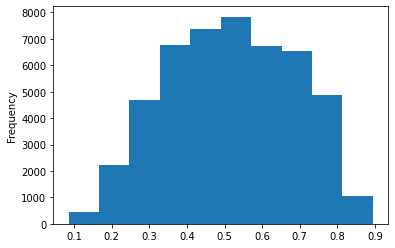

In [193]:
prediction['target_g'].plot(kind='hist')

In [194]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)


In [ ]:
46.86 * 3.24

151.8264